# Alpha Decay within Trend Following

This notebook will look at the alpha decay that is used within the [*Trend’s Not Dead (It’s just moved to a trendier neighbourhood)*](https://www.cmegroup.com/education/files/trends-not-dead-babbedge-kerson-2019.pdf) By Gresham LLC. This notebook will the same approach they use within their paper

## Packages

In [1]:
import os
import sys 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TrendisNotDead\root\src")
from SignalGenerator import SignalGenerator

## Analyzing Alpha Decay

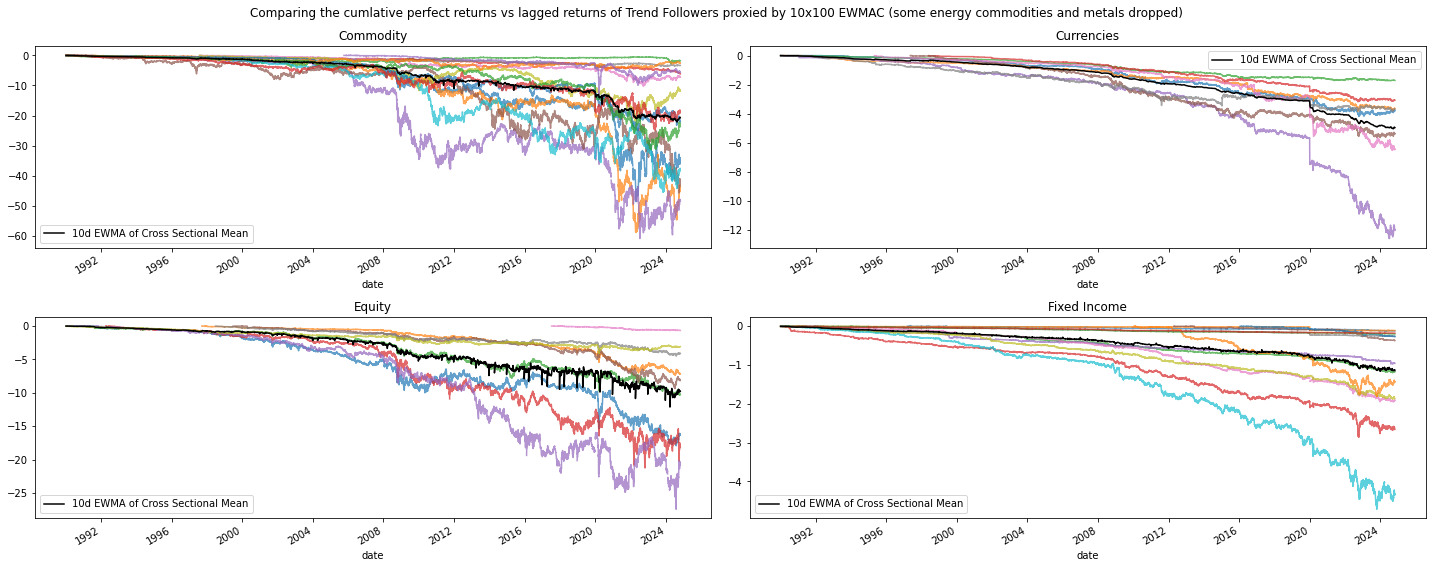

In [80]:
def plot_raw_rtn_comparison() -> pd.DataFrame: 
    
    df_tickers = (SignalGenerator().df_tickers[
        ["contract", "kind"]])

    bad_tickers = ["NG", "QS", "CL", "CO", "LN", "HO", "LH", "CT"]
    df_combined = (SignalGenerator().get_cum_rtn().query(
        "rtn_group == 'px_rtn'")
        [["date", "security", "alpha_decay"]].
        rename(columns = {"security": "contract"}).
        merge(right = df_tickers, how = "inner", on = ["contract"]).
        query("contract != @bad_tickers"))

    variables   = df_combined.kind.drop_duplicates().sort_values().to_list()
    fig, axes   = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()):

        df_plot = (df_combined.query(
            "kind == @variable").
            pivot(index = "date", columns = "contract", values = "alpha_decay"))

        (df_plot.plot(
            ax     = ax,
            legend = False,
            alpha  = 0.7,
            title  = variable))

        (df_plot.mean(
            axis = 1).
            ewm(span = 10, adjust = False).
            mean().
            to_frame(name = "10d EWMA of Cross Sectional Mean").
            plot(ax = ax, color = "black"))

    fig.suptitle("Comparing the cumlative perfect returns vs lagged returns of Trend Followers proxied by 10x100 EWMAC (some energy commodities and metals dropped)")
    plt.tight_layout()
    
plot_raw_rtn_comparison()

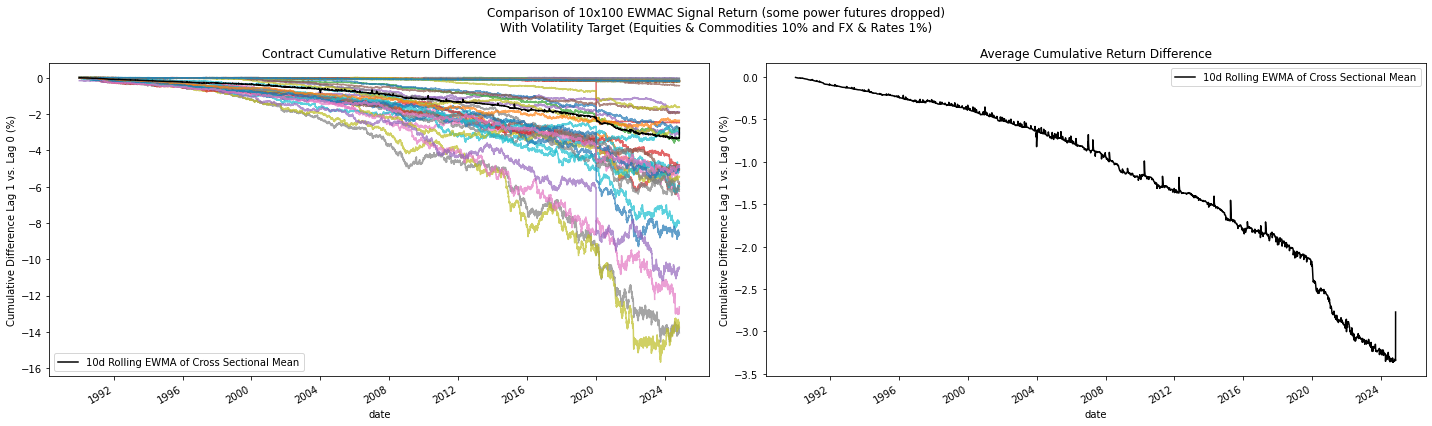

In [88]:
def plot_cross_asset_trend_alpha_decay() -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_wider = (SignalGenerator().get_cum_rtn().query(
        "rtn_group == 'vol_rtn'").
        query("security != ['NG', 'QS']").
        pivot(index = "date", columns = "security", values = "alpha_decay"))

    df_mean = (df_wider.mean(
        axis = 1).
        to_frame(name = "10d Rolling EWMA of Cross Sectional Mean").
        ewm(span = 10, adjust = False).
        mean())

    (df_wider.plot(
        legend = False, 
        alpha  = 0.7,
        ax     = axes[0]))

    axes[0].set_title("Contract Cumulative Return Difference")
    axes[1].set_title("Average Cumulative Return Difference")

    for ax in axes.flatten(): 

        df_mean.plot(ax = ax, color = "black")
        ax.set_ylabel("Cumulative Difference Lag 1 vs. Lag 0 (%)")

    fig.suptitle(
        "Comparison of 10x100 EWMAC Signal Return (some power futures dropped)\nWith Volatility Target (Equities & Commodities 10% and FX & Rates 1%)")
    plt.tight_layout()
    
plot_cross_asset_trend_alpha_decay()

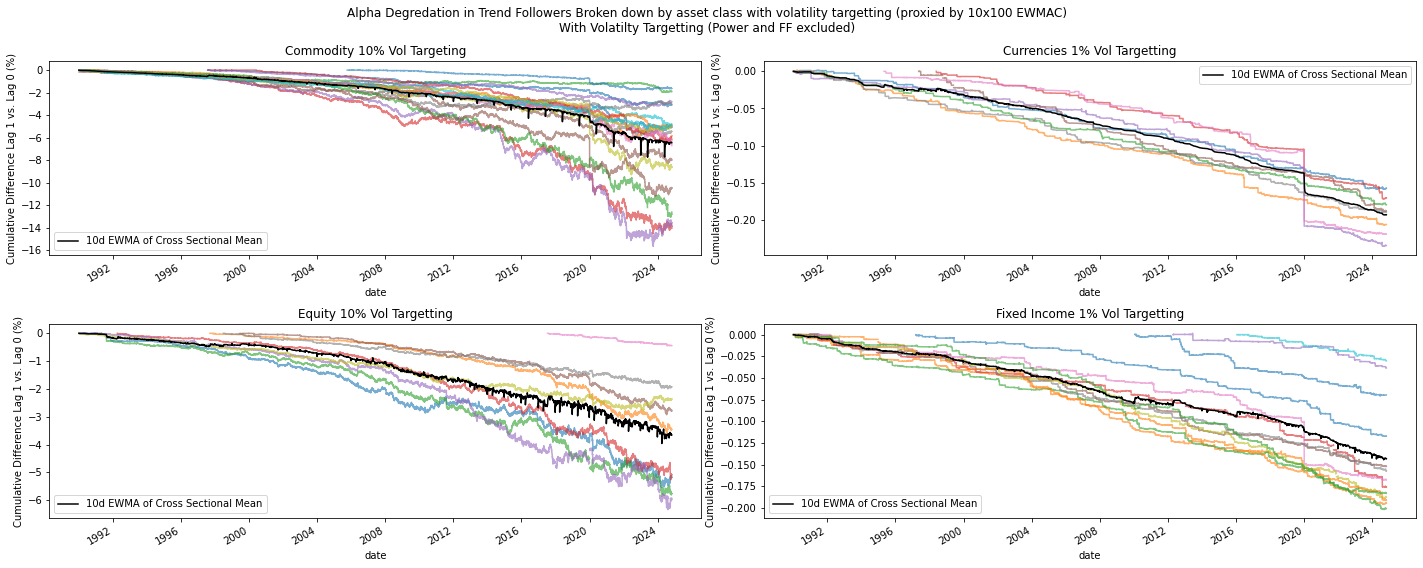

In [127]:
def plot_asset_breakdown_alpha_decay() -> plt.Figure: 
    
    df_tickers = (SignalGenerator().df_tickers[
        ["contract", "kind"]])

    df_tmp = (SignalGenerator().get_cum_rtn().query(
        "rtn_group == 'vol_rtn'").
        rename(columns = {"security": "contract"}).
        merge(right = df_tickers, how = "inner", on = ["contract"]))

    variables = df_tmp.kind.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (20,8))

    renamer = {
        "Commodity"   : "10% Vol Targeting",
        "Currencies"  : "1% Vol Targetting",
        "Equity"      : "10% Vol Targetting",
        "Fixed Income": "1% Vol Targetting"}

    for variable, ax in zip(variables, axes.flatten()):

        df_plot = (df_tmp.query(
            "kind == @variable").
            query("contract != ['NG', 'QS', 'FF']").
            pivot(index = "date", columns = "contract", values = "alpha_decay"))

        (df_plot.plot(
            ax     = ax,
            legend = False,
            alpha  = 0.6))

        (df_plot.mean(
            axis = 1).
            ewm(span = 10, adjust = False).
            mean().
            to_frame(name = "10d EWMA of Cross Sectional Mean").
            plot(
                ax     = ax,
                color  = "black",
                ylabel = "Cumulative Difference Lag 1 vs. Lag 0 (%)",
                title  = variable + " " + renamer[variable]))

    fig.suptitle("Alpha Degredation in Trend Followers Broken down by asset class with volatility targetting (proxied by 10x100 EWMAC)\nWith Volatilty Targetting (Power and FF excluded)")
    plt.tight_layout()
    
plot_asset_breakdown_alpha_decay()

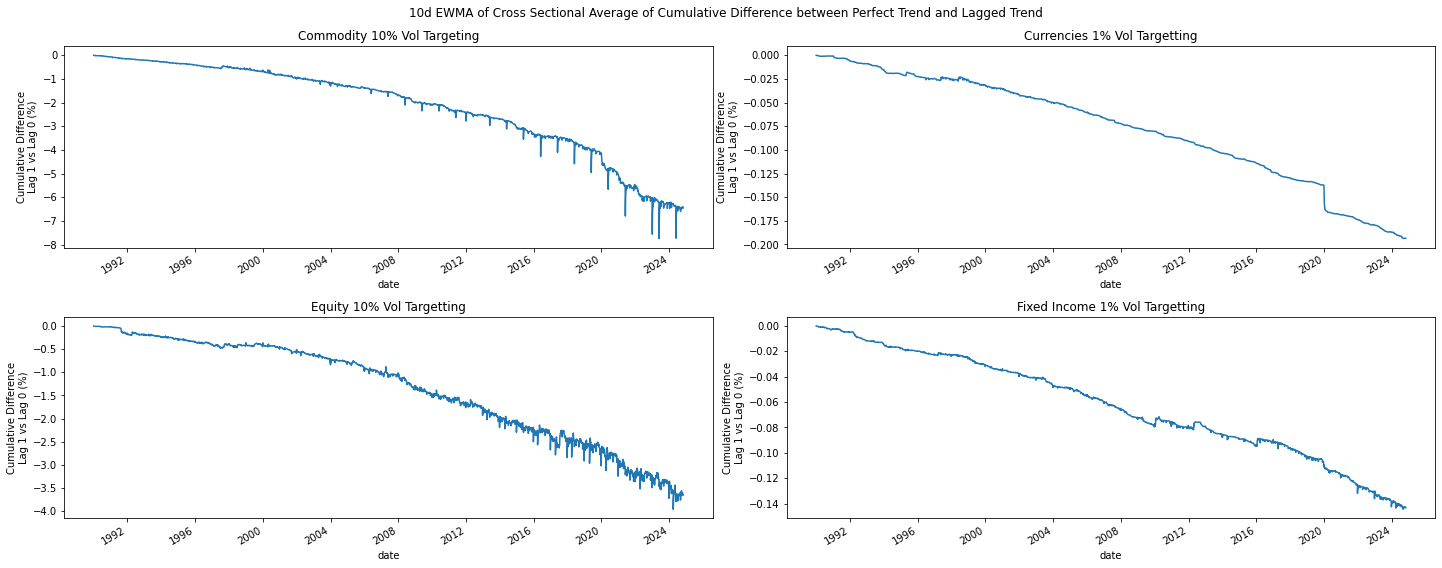

In [153]:
def plot_average_asset_difference() -> plt.Figure:
    
    df_tickers = (SignalGenerator().df_tickers[
        ["contract", "kind"]])

    df_tmp = (SignalGenerator().get_cum_rtn().query(
        "rtn_group == 'vol_rtn'").
        rename(columns = {"security": "contract"}).
        query("contract != ['NG', 'QS', 'FF']").
        merge(right = df_tickers, how = "inner", on = ["contract"]))

    df_longer = (df_tmp[
        ["date", "alpha_decay", "kind"]].
        groupby(["date", "kind"]).
        agg("mean").
        reset_index().
        pivot(index = "date", columns = "kind", values = "alpha_decay").
        ewm(span = 10, adjust = False).
        mean().
        reset_index().
        melt(id_vars = "date"))

    renamer = {
        "Commodity"   : "10% Vol Targeting",
        "Currencies"  : "1% Vol Targetting",
        "Equity"      : "10% Vol Targetting",
        "Fixed Income": "1% Vol Targetting"}

    variables = df_longer.kind.drop_duplicates().sort_values()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_longer.query(
            "kind == @variable").
            set_index("date")
            [["value"]].
            plot(
                ax     = ax,
                legend = False,
                title  = variable + " " + renamer[variable],
                ylabel = "Cumulative Difference\nLag 1 vs Lag 0 (%)"))

    fig.suptitle("10d EWMA of Cross Sectional Average of Cumulative Difference between Perfect Trend and Lagged Trend")
    plt.tight_layout()
    
plot_average_asset_difference()